# IBM Applied Data Science Capstone

**Title**: Segmenting and clustering postal code areas in the Metropolitan region Rhine-Neckar<br>
**Author**: Patrick Michl [[LinkedIn](https://www.linkedin.com/in/patrick-michl), [FrootLab](https://www.frootlab.org/authors/patrick), [GitHub](https://github.com/fishroot)]<br>
**Date/Version**: 2020.02<br>
**License**: CC BY 4.0<br>

## Preliminaries

### Import generic packages

In [1]:
# Standard library imports
import functools
import itertools
import sys

# Common library imports
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

### Install packages for geospatial data

In [2]:
# GeoPandas (http://geopandas.org)
try:
    import geopandas as gpd
except ImportError:
    print('Installing package geopandas')
    !conda install --yes --quiet --prefix {sys.prefix} geopandas

# Descartes (https://pypi.org/project/descartes)
try:
    import descartes
except ImportError:
    print('Installing package descartes')
    !conda install --yes --quiet --prefix {sys.prefix} descartes

# Contextily (https://github.com/darribas/contextily)
try:
    import contextily
except ImportError:
    print('Installing package contextily')
    !conda install -c conda-forge --yes --quiet --prefix {sys.prefix} contextily

Installing package geopandas
Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    shapely-1.6.4              |   py36h86c5351_0         330 KB
    libspatialindex-1.9.3      |       he6710b0_0         3.1 MB
    munch-2.5.0                |             py_0          16 KB
    freexl-1.0.5               |       h14c3975_0          44 KB
    pyproj-1.9.6               |   py36h14380d9_0          76 KB
    kealib-1.4.7               |       hd0c454d_6         175 KB
    openjpeg-2.3.0             |       h05c96fa_1         456 KB
    geos-3.7.1                 |       he6710b0_0         1.6 MB
    cligj-0.5.0                |           py36_0          12 KB
    poppler-0.65.0             |       h581218d_1         1.6 MB
    poppler-data-0.4.9

### Facilitate map visualization of geospatial data

In [3]:
import contextily as ctx
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_map(gdf: gpd.GeoDataFrame, **kwds) -> None:
    """Plot map with basemap given by web map tile and optional legend."""

    # Set defaults
    kwds = {**{
        'legend': False,
        'legend_kwds': {},
        'alpha': .5,
        'edgecolor': 'k',
        'figsize': (15, 10),
        'basemap': ctx.providers.Stamen.Terrain,
        'devide': False}, **kwds}

    # Separate special keywords
    figsize = kwds.pop('figsize')
    basemap = kwds.pop('basemap')
    devide = kwds.pop('devide')
    
    # In order to use web map tiles, the coordinate reference system
    # of the GeoDataFrame is changed to Web Mercator (EPSG 3857)
    gdf_map = gdf.to_crs(epsg=3857)
    
    # Create figure and axis objects
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    plt.tight_layout()
    
    # Plot map with optional legend
    if kwds['legend'] and devide:
        divider = make_axes_locatable(ax)
        
        if 'orientation' in kwds['legend_kwds'] \
            and kwds['legend_kwds']['orientation'] == 'horizontal':
            cax = divider.append_axes("bottom", size="5%", pad=0.1)
        else:
            cax = divider.append_axes("right", size="5%", pad=0.1)
        gdf_map.plot(ax=ax, cax=cax, **kwds)
    else:
        gdf_map.plot(ax=ax, **kwds)
    
    # Add basemap
    ctx.add_basemap(ax, url=basemap)

### Setup and facilitate access to IBM cloud objects

In [4]:
# The code was removed by Watson Studio for sharing.

### Setup and facilitate access to Foursquare API

In [5]:
# The code was removed by Watson Studio for sharing.

## Data integration

### Rhein-Neckar Wiki

**Description**: The Rhein-Neckar Wiki is a free knowledge database for the metropolitan region Rhine-Neckar. It collects information about associated cities, current and past events. Due to the wiki prin-ciple, the data is validated by the community. The provided information is licensed under the terms and conditions of the CC BY-NC-SA 4.0  and published by the Rhein-Neckar Wiki authors.

**Integration**: The integrated table comprises the administrative `type` (1=*District-free City*, 2=*County City*, 3=*County Municipality*), federal `state`, `district` and `boroughs` of all MRN zip-code areas. It is used as the primary source for an administrative definition of the MRN.

In [6]:
# Create file handler to CSV file in IBM cloud
file = get_ibm_file('MRN.csv')

# Create DataFrame from CSV file
print("loading CSV file from IBM cloud")
mrn = pd.read_csv(file)
print(f"found {len(mrn)} entries")

# Aggregate state, district and boroughs information by zip-codes
print("aggregate entries to zip-code areas")
first = lambda x: x.iloc[0]
join = lambda x: '|'.join(x)
mrn = mrn.groupby('zip').agg({
    'type': first,
    'state': join,
    'district': join,
    'boroughs': join})

# Filter pipe separated strings to unique values
for col in ['state', 'district', 'boroughs']:
    mrn[col] = mrn[col].str.split('|').map(set).str.join('|')

# Sort and reset index
mrn = mrn.sort_index().reset_index()

# Report Rhein-Neckar Wiki data integration results
print(f"found {len(mrn)} zip-code areas within the MRN")

loading CSV file from IBM cloud
found 323 entries
aggregate entries to zip-code areas
found 237 zip-code areas within the MRN


In [7]:
# Sanity check: Heidelberg should comprise 15 boroughs and 8 zip-code areas
# https://de.wikipedia.org/wiki/Heidelberg
hd = mrn[mrn['district'].str.contains('Heidelberg')]
hd.filter(items=['zip', 'boroughs'])

,zip,boroughs
127,69115,Weststadt|Bergheim|Bahnstadt
128,69117,Altstadt
129,69118,Ziegelhausen|Schlierbach
130,69120,Neuenheim
131,69121,Handschuhsheim
132,69123,Wieblingen|Pfaffengrund
133,69124,Kirchheim
134,69126,Emmertsgrund|Rohrbach|Südstadt|Boxberg


### OpenStreetMap.org

**Description**: OpenStreetMap is a collaborative project to create a free editable map of the world. The geodata underlying the map is considered the primary output of the OSM project. The creation and growth of OSM has been motivated by restrictions on use or availability of map data across much of the world, and the advent of inexpensive portable satellite navigation devices. The data is licensed under the terms and conditions of the Open Database License, aggregated by SUCHE-POSTLEITZAHL.ORG and hosted by OpenDataSoft.

**Integration**: The integrated table comprises names and the geospatial shapes of the German zip-code areas. It is used to define the spatial aggregation bounds within the individual zip-code areas of the MRN.

In [8]:
# Create file handler to GeoJSON file in IBM cloud
file = get_ibm_file('DE_Geo.geojson')

# Create GeoDataFrame from GeoJSON file from OpenStreetMap
print("loading geospatial data of germany as GoeJSON file from IBM cloud")
osm = gpd.read_file(file)
print(f"found {len(osm)} entries")

# Rename columns
osm = osm.rename(columns={
    'note': 'name',
    'plz': 'zip'})

# Drop entries with missing geospatial information
missing = osm['geometry'].isnull().sum()
if missing:
    print(f"deleting {missing} entries with missing georeferences")
    osm = osm.dropna()

# Convert postal codes to integers
osm['zip'] = osm['zip'].apply(pd.to_numeric)

# Apply spatial aggregation by zip-codes
print("aggregating geometric shapes to zip-code areas")
osm = osm.dissolve(by='zip')
print(f"found {len(osm)} georeferences of zip-code areas in germany")

# Sort GeoDataFrame by zip-codes and reset index
osm = osm.sort_index().reset_index()

# Integrate geospatial data to the metropolitan region Rhine-Neckar
mrn = osm.merge(mrn, on='zip', how='inner', suffixes=('_old', ''))
mrn = mrn.drop(columns=filter(lambda col: '_old' in col, mrn.columns))

# Report Rhein-Neckar Wiki data integration results
print(f"found {len(mrn)} georeferences of zip-code areas in the MRN")

loading geospatial data of germany as GoeJSON file from IBM cloud
found 8699 entries
deleting 2 entries with missing georeferences
aggregating geometric shapes to zip-code areas
found 8179 georeferences of zip-code areas in germany
found 237 georeferences of zip-code areas in the MRN


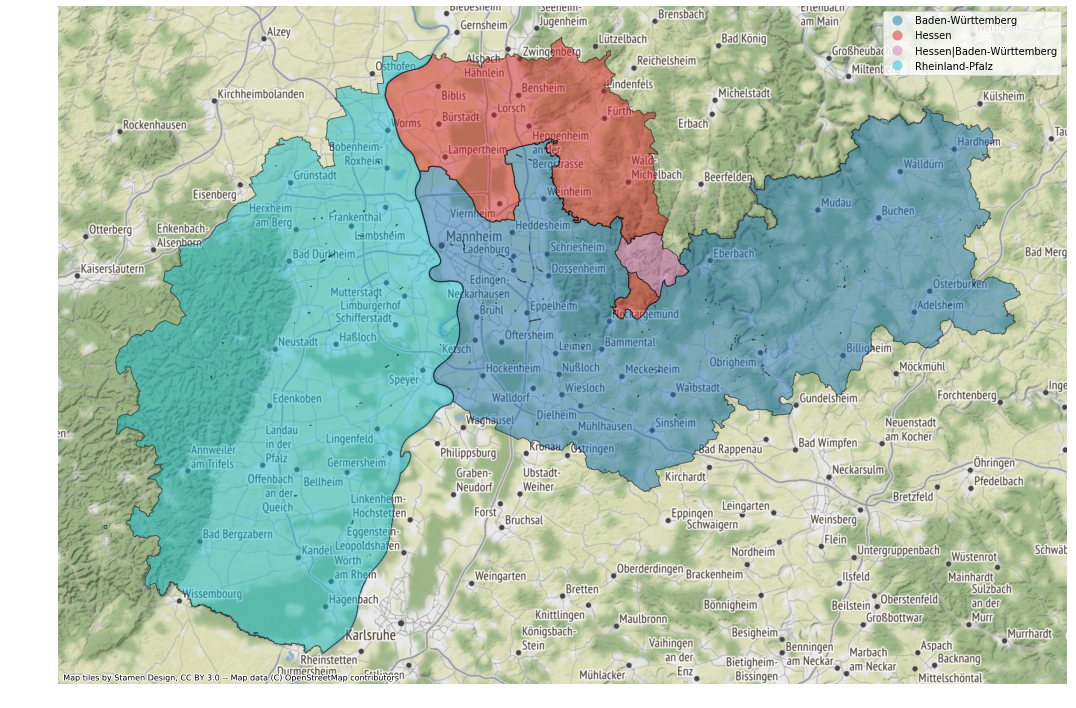

In [9]:
# Sanity Check: Plot map of zip-code areas in the MRN by state
plot_map(mrn.dissolve('state').reset_index(),
     column='state',
     legend=True)

### Rhein-Neckar-Verkehr GmbH

**Description**: The Rhein-Neckar-Verkehr GmbH (RNV) is the most important traffic alliance in the met-ropolitan region Rhein-Neckar. It operates suburban railways, trams and bus routes in Mannheim, Heidelberg and Ludwigshafen. The RNV provides an open data portal with data, licensed under the terms and conditions of the DL-DE-BY-2.0.

**Integration**: The integrated table comprises an `id`, a `name` and the coordinates of all active stops operated by the RNV, given in `lat` (latitude) and `lon` (longitude). Thereupon, the coordinates are used to assign zip-codes based on the OSM data. It is used to summarize the appearances of RNV stops within the individual zip-code areas of the MRN.

In [10]:
# Create file handler to JSON file in IBM cloud
file = get_ibm_file('MRN_PublicTransport.json')

# Create iterable of RNV stops from JSON file
print("loading RNV stop data as JSON file from IBM cloud")
stops = pd.read_json(file).transpose()['stops']
stops = itertools.chain.from_iterable(stops)

# Create DataFrame from iterable
rnv = pd.DataFrame(stops)
print(f"found {len(rnv)} RNV stops")

# Create GeoDataFrame from DataFrame
rnv = gpd.GeoDataFrame(rnv,
    geometry=gpd.points_from_xy(rnv.lon, rnv.lat),
    crs={'init' :'epsg:4326'})

# Calculate zip-codes for RNV stops (by shapes of the zip-code areas)
print(f"trying to locate the zip-codes of {len(rnv)} RNV stops")
rnv['zip'] = pd.Series(0, dtype=int)
for i, p in rnv.iterrows():
    for j, q in mrn.iterrows():
        if p['geometry'].within(q['geometry']):
            rnv.at[i, 'zip'] = q['zip']
            break

# Delete non-locatable RNV stops
unknown = rnv.loc[rnv['zip'] == 0].index
if len(unknown):
    print(f"deleting {len(unknown)} non-locatable RNV stops")
    rnv.drop(unknown, inplace=True)

# Delete outliers (RNV stops with zip-code not in MRN)
outliers = rnv.loc[~rnv['zip'].isin(rnv['zip'])].index
if len(outliers):
    print(f"deleting {len(outliers)} RNV stops outside the MRN")
    rnv.drop(outliers, inplace=True)

# Report RNV data integration results
print(f"found {len(rnv)} unique locatable RNV stops within the MRN")    

loading RNV stop data as JSON file from IBM cloud
found 1987 RNV stops
trying to locate the zip-codes of 1987 RNV stops
found 1987 unique locatable RNV stops within the MRN


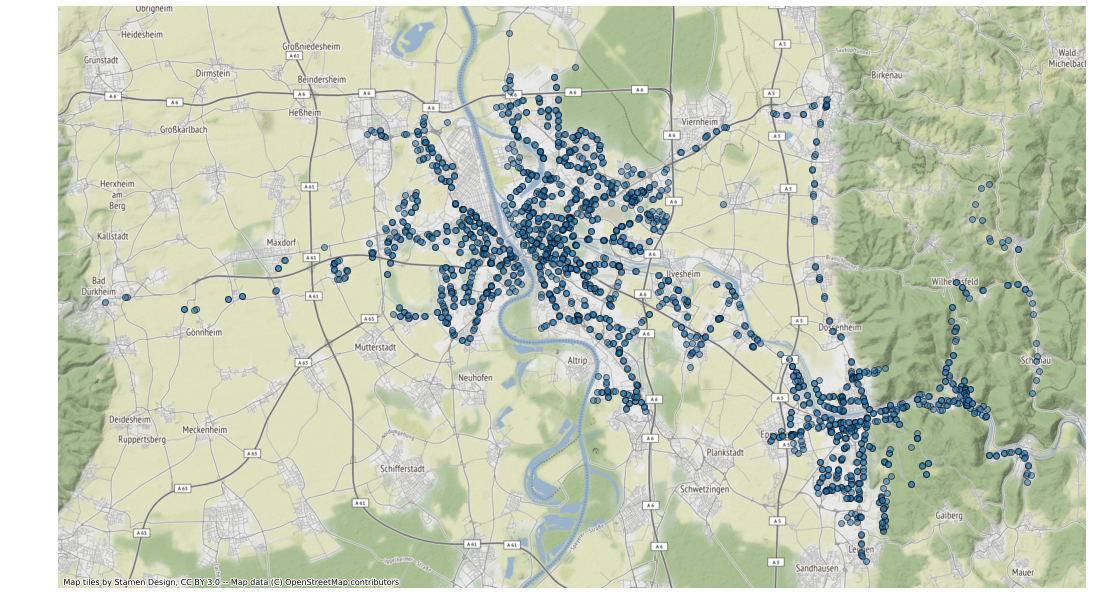

In [11]:
# Sanity Check: Plot map of RNV Stops
plot_map(rnv)

### Federal Statistical Office of Germany

**Description**: The federal statistical office of Germany provides geospatial population data for Ger-many. This data is collected in a national population census, which is held at irregular time intervals. The most recent census, that is provided is the 2011 European Union census. The data is licensed under the terms and conditions of the DL-DE-BY-2.0 and aggregated to zip-code areas by SUCHE-POSTLEITZAHL.ORG.

**Integration**: The integrated table is of type A and comprises `population` data for all `zip`-code areas of the MRN. It is used to incorporate demographic information into the data analysis.

In [12]:
# Create file handler to CSV file in IBM cloud
file = get_ibm_file('DE_Population.csv')

# Create DataFrame from CSV file
print("loading census data as CSV file from IBM cloud")
census = pd.read_csv(file)
print(f"found {len(census)} census entries for zip-code areas in germany")

# Rename columns
census = census.rename(columns={
    'plz': 'zip',
    'einwohner': 'population'})

# Integrate population data into MRN GeoDataFrame
mrn = mrn.merge(census, on='zip', how='left', suffixes=('_old', ''))
mrn = mrn.drop(columns=filter(lambda col: '_old' in col, mrn.columns))

# Report census data integration results
print(f"found {mrn['population'].count()} census entries for zip-code areas within the MRN")

loading census data as CSV file from IBM cloud
found 8168 census entries for zip-code areas in germany
found 237 census entries for zip-code areas within the MRN


In [13]:
# Sanity check: The Population of Heidelberg, Altstadt should be ~10k
# https://de.wikipedia.org/wiki/Heidelberger_Altstadt
hd = mrn[mrn['district'].str.contains('Heidelberg')]
hd.filter(items=['boroughs', 'population'])

,boroughs,population
127,Weststadt|Bergheim|Bahnstadt,21900
128,Altstadt,11052
129,Ziegelhausen|Schlierbach,13468
130,Neuenheim,15981
131,Handschuhsheim,16725
132,Wieblingen|Pfaffengrund,18293
133,Kirchheim,17066
134,Emmertsgrund|Rohrbach|Südstadt|Boxberg,32296


### Foursquare Labs, inc.

**Description**: Foursquare is an American provider for location data, collected via billions of check-ins. The company rose to prominence by popularizing the concept of real-time location sharing. The data is provided via API and therefore reflects the current data stock provided by Foursquare. The data is licensed under the terms and conditions of the Foursquare License Agreement.

**Integration**: The integrated tables comprise location data, given by the venues of different categories and the category types. They are used to summarize the appearances of venues of the respective types within the individual zip-code areas of the MRN.

In [21]:
# Fetch venues within the metropolitan region Rhein-Neckar
print("fetching venues from Foursquare API")
areas = zip(mrn['zip'], ['de'] * len(mrn['zip']))
venues = batch_search_venues(areas)

# Remove duplicates
venues = venues.drop_duplicates(subset='id')
print(f"found {len(venues)} unique venues")

# Add category and rubric information
print("fetching venue categories from Foursquare API")
categories = get_categories().rename(columns={'group': 'rubric'})
venues = pd.merge(venues, categories, on='cid')

# Drop dispensable columns
venues.drop(columns=['cid', 'gid'])

# Create GeoDataFrame
venues = gpd.GeoDataFrame(venues,
    geometry=gpd.points_from_xy(venues.lng, venues.lat),
    crs={'init' :'epsg:4326'})

# Locate venues with missing zip-codes
print(f"trying to locate the zip-codes of {(venues['zip'] == 0).sum()} venues")
for i, p in venues.iterrows():
    if p['zip'] > 0:
        continue
    for j, q in mrn.iterrows():
        if p['geometry'].within(q['geometry']):
            venues.at[i, 'zip'] = q['zip']
            continue

# Delete non-locatable venues
unknown = venues.loc[venues['zip'] == 0].index
if len(unknown):
    print(f"deleting {len(unknown)} non-locatable venues")
    venues.drop(unknown, inplace=True)

# Delete outliers (zip-code not in MRN)
outliers = venues.loc[~venues['zip'].isin(mrn['zip'])].index
if len(outliers):
    print(f"deleting {len(outliers)} venues outside the MRN")
    venues.drop(outliers, inplace=True)

# Report Foursquare integration results
print(f"found {len(venues)} unique locatable venues within the MRN")

fetching venues from Foursquare API


JSONDecodeError: Expecting value: line 2 column 1 (char 1)

In [ ]:
# Sanity Check: Plot map of Foursquare venues in Mannheim, Ludwigshafen and Heidelberg
ziparea = mrn[mrn['district'].str.contains('Mannheim|Ludwigshafen|Heidelberg')]['zip']
plot_map(venues[venues['zip'].isin(ziparea)],
    column='rubric',
    legend=True)

## Data Transformation

### Area Estimation
In accordance to the OGC standard the attribute OSM.geometry contains encoded multipolygons with a polar coordinate reference system (EPSG:4326,  e.g. used by GPS satellite navigation). The area estimation therefore requires a preceded transformation into Cartesian coordinates. This allows the subsequent application of the Shoelace formula to derive the areas for all simply con-nected polygons, which in turn are summed up to the multipolygons, that describe the zip-code are-as. Finally, these estimates are stored in the float type attribute MRN.area.

In [ ]:
# Project geometry from degrees to cartesian coordinates
cart = mrn['geometry'].to_crs({'proj':'cea'})

# The Attribute .area automatically derives the area,
# by application of the Shoelace formula with a subsequent summation
# Add column 'area' with area estimate in unit [km²]
mrn['area'] = cart.area / 10**6

# Sanity check: The Area of Heidelberg, Altstadt should be ~14km²
# https://de.wikipedia.org/wiki/Heidelberger_Altstadt
hd = mrn[mrn['district'].str.contains('Heidelberg')]
hd.filter(items=['boroughs', 'area'])

### Population density estimation

First, the tables MRN and Census are left outer joined on their common attribute zip, which provides the integer attribute MRN.population. Thereupon the quotient of the attributes MRN.population and MRN.area is stored within the float type attribute MRN.population_density.

In [ ]:
# Add population density
mrn['population_density'] = mrn['population'] / mrn['area']

# Sanity check: The population density of Heidelberg, Altstadt should be about ~750 people/km²
# https://de.wikipedia.org/wiki/Heidelberger_Altstadt
hd = mrn[mrn['district'].str.contains('Heidelberg')]
hd.filter(items=['boroughs', 'population_density'])

### RNV stop count, area density and per capita density

The table RNV is grouped by its attribute zip. Afterwards the sizes of the groups are stored within the integer attribute MRN.rnv_count. Thereby the NULL values are initialized by zeros.  At this foun-dation, the float attributes MRN.rnv_density and MRN.rnv_supply are derived by a respectively division of MRN.rnv_count through MRN.area and MRN.population∙0.001.

In [ ]:
# Count number of RNV stops per zip-code area
# and merge into MRN GeoDataFrame
total = (rnv.groupby('zip').count())['id'].reset_index()
total = total.rename(columns={'id': 'rnv_count'})
mrn = mrn.merge(total, on='zip', how='left', suffixes=('_old', ''))
mrn = mrn.drop(columns=filter(lambda col: '_old' in col, mrn.columns))

# Fill missing values with zeros
mrn['rnv_count'] = mrn['rnv_count'].fillna(0).astype(int)

# Calculate per area and per capita densities,
# respectively given by the total number of appearances
# per km² and per 1000 residents
mrn['rnv_density'] = mrn['rnv_count'] / mrn['area']
mrn['rnv_supply'] = mrn['rnv_count'] / mrn['population'] * 1000

# Sanity check: List RNV stop count and densities in Heidelberg
hd = mrn[mrn['district'].str.contains('Heidelberg')]
hd.filter(items=['boroughs', 'rnv_count', 'rnv_density', 'rnv_supply'])

### Foursquare venue count, area density, per capita density and ratio (per rubric)
The Foursquare tables Venues and Categories are left outer joined on the respective attributes `Venues.category` and `Categories.name`, which provides the string attribute `Venues.rubric`. This attribute comprises the values: Arts & Entertainment, College & University, Event, Food, Outdoors & Recreation, Professional & Other Places, Residence, Shop & Service, Travel & Transport. Thereupon the table Venues is grouped by the attribute zip and for each group the number of objects of each rubric is stored within a respective integer attribute `MRN.[RUBRIC]_count`. Thereupon also the sum of all venues per zip-code area is stored within the integer attribute `MRN.venue_count`. At this foundation, the area density, the per capita density and the group ratio are derived by a division of `MRN.[RUBRIC]_count` through `MRN.area`, `MRN.population`∙10-3 and `MRN.venue_count` and stored within the float attributes `MRN.[RUBRIC]_density`, `MRN.[RUBRIC]_supply` and `MRN.[RUBRIC]_ratio`

In [ ]:
# Count number of Foursquare venues per zip-code area
colname = lambda s: s.split(maxsplit=1)[0].lower() + '_count'
colfunc = lambda s: lambda df: (df == s).sum()
mapping = lambda s: {'venue_count': len, **dict(zip(map(colname, s), map(colfunc, s)))}
count = mapping(categories['rubric'].unique())
cols = dict(zip(count.keys(), [venues['rubric']] * len(count)))
fs = venues.assign(**cols).groupby('zip').agg(count)

# Merge counts into MRN GeoDataFrame
mrn = mrn.merge(fs, on='zip', how='left', suffixes=('_old', ''))
mrn = mrn.drop(columns=filter(lambda col: '_old' in col, mrn.columns))

# Fill missing values with zeros
mrn['venue_count'] = mrn['venue_count'].fillna(0).astype(int)
for col in map(colname, categories['rubric'].unique()):
    mrn[col] = mrn[col].fillna(0).astype(int)

# Calculate per area densities, per capita densities and proportions,
# respectively given by the total number of appearances, devided by
# the area, the population [in 1000] and the total number of venues
for col in cols.keys():
    mrn[col.replace('_count', '_density')] = mrn[col] / mrn['area']
    mrn[col.replace('_count', '_supply')] = mrn[col] / mrn['population'] * 1000
    if col != 'venue_count':
        mrn[col.replace('_count', '_ratio')] = mrn[col] / mrn['venue_count']

# Sanity check: List number and densities of Foursquare venues in Heidelberg
# Additionally list numer, densities and ratio of Foursquare venues of rubric Food (Restaurant etc.)
hd = mrn[mrn['district'].str.contains('Heidelberg')]
hd.filter(items=['boroughs', 'venue_count', 'venue_density', 'venue_supply'])

## Data Cleansing

Whereas the RNV data may be assumed to be objective, the Foursquare data depends on the coop-eration of its users, and therefore may be assumed to be subjective. It is therefore reasonable to evaluate the Foursquare data in terms of its probabilities, and thereupon to detect and filter anoma-lies within the data. Thereby it must be considered that a probability density estimation of the total number of Foursquare venues is more reliable, than density estimations of the individual rubrics.

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import PCA
from scipy.stats import norm as gauss
from scipy.stats import multivariate_normal

%config InlineBackend.figure_formats = ['svg']
sns.set()
scform = matplotlib.ticker.ScalarFormatter()
colors = [(1, 1, 1, 0.0), (0.47, 0.58, 0.77, 0.95)]
cm = LinearSegmentedColormap.from_list('my_list', colors, N=200)

### Detect anomalies in venues per capita

In [ ]:
features = ['population', 'venue_count']
x, y = mrn[features[0]], mrn[features[1]]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 5))
plt.tight_layout()

# Explorative data analysis
# Plot venues against population in linear scale
ax1.set(xlim=[x.min(), x.max() * 1.05], ylim=[y.min(), y.max() * 1.05])
sns.scatterplot(*features, data=mrn, ax=ax1, s=80, alpha=0.7)
ax1.set(xlabel='', ylabel='', title='Linear Scale')

# Plot venues against population in semi-logarithmic scale
ax2.set(xlim=[x.min() + 1, x.max() * 1.3], ylim=[y.min(), y.max() * 1.05], xscale='log')
ax2.get_xaxis().set_major_formatter(scform)
sns.scatterplot(*features, data=mrn, ax=ax2, s=80, alpha=0.7)
ax2.set(xlabel='', ylabel='', title='Semi-logarithmic Scale')

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 5))
plt.tight_layout()

# Plot venues against population in semi-logarithmic scale
ax1.set(xlim=[x.min(), x.max() * 1.05], ylim=[y.min() + 1, y.max() * 1.3], yscale='log')
ax1.get_yaxis().set_major_formatter(scform)
sns.scatterplot(*features, data=mrn, ax=ax1, s=80, alpha=0.7)
ax1.set(xlabel='', ylabel='', title='Semi-logarithmic Scale')

# Plot venues against population in logarithmic scale
ax2.set(xlim=[x.min() + 1, x.max() * 1.3], ylim=[y.min() + 1, y.max() * 1.3], xscale='log', yscale='log')
ax2.get_xaxis().set_major_formatter(scform)
ax2.get_yaxis().set_major_formatter(scform)
sns.scatterplot(*features, data=mrn, ax=ax2, s=80, alpha=0.7)
ax2.set(xlabel='', ylabel='', title='Logarithmic Scale')

In [ ]:
threshold = 0.05

# Transform features: nonlinear transformation, normalisation
log = lambda x: np.log(x + 1)
norm = lambda x: (x.T - x.mean(axis=1)) / x.std(axis=1)
trans = lambda x: norm(log(x))

# Calculate principal components of transformed data:
# While the first principal component describes the
# relationship between the features, the further principal
# components describe the deviation from this relationship
data = np.array(list(map(lambda c: mrn[c], features)))
pca = PCA(n_components=data.shape[0])
pca.fit(trans(data))
V = pca.components_

# Calculate p-value by a normal distribution
# along the second principal component
# Transform and project data to the 2nd and further principal components
prj = lambda x: np.dot(trans(x), V[1:, :].T)

# Fit multivariate gaussian to projected data
Z = prj(data)
mean = Z.mean(axis=0)
cov = np.cov(Z.T)
ppdf = multivariate_normal(mean, cov).pdf

# Calculate p-values for all zip-code areas
pdf = lambda x: ppdf(prj(x))
mrn['venue_supply_pvalue'] = pdf(data)

# Sanity Check: Plot probability density with threshold
x, y = mrn[features[0]], mrn[features[1]]

# Create X, Y and Z grids as 2d numpy arrays
x_axis = np.linspace(x.min() + 1, x.max() * 1.3, 800)
y_axis = np.linspace(y.min() + 1, y.max() * 1.3, 800)
X, Y = np.meshgrid(x_axis, y_axis)
Z = pdf(np.array([X.flatten(), Y.flatten()])).reshape(X.shape)

# Create figure
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 5))
plt.tight_layout()

# Create plot of probability density
ax1.set(xlim=[x.min() + 1, x.max() * 1.3], ylim=[y.min() + 1, y.max() * 1.3], xscale='log', yscale='log')
ax1.get_xaxis().set_major_formatter(scform)
ax1.get_yaxis().set_major_formatter(scform)
ax1.contourf(X, Y, Z, 100, cmap=cm)
sns.scatterplot(*features, data=mrn, ax=ax1, s=80, alpha=0.7)
ax1.set(xlabel='', ylabel='', title='Estimated PDF')

# Create plot of detected anomalies
ax2.set(xlim=[x.min() + 1, x.max() * 1.3], ylim=[y.min() + 1, y.max() * 1.3], xscale='log', yscale='log')
ax2.get_xaxis().set_major_formatter(scform)
ax2.get_yaxis().set_major_formatter(scform)
contours = ax2.contourf(X, Y, Z, 100, cmap=cm)
clines = ax2.contour(X, Y, Z, [0.02],
    colors=['black'],
    linestyles=['dashed'])
sns.scatterplot(*features,
    data=mrn[mrn['venue_supply_pvalue'] >= threshold],
    ax=ax2, s=80, alpha=0.7)
sns.scatterplot(*features,
    data=mrn[mrn['venue_supply_pvalue'] < threshold],
    ax=ax2, s=100, alpha=0.9, color='red')
ax2.set(xlabel='', ylabel='', title='Detected Anomalies')

In [ ]:
# Sanity check: List detected anomalies in venues per capita
mrn[mrn['venue_supply_pvalue'] < threshold].filter(items=[
    'state', 'district', 'boroughs',
    'population', 'venue_count', 'venue_supply',
    'venue_supply_pvalue']).sort_values(by='venue_supply_pvalue')

### Density-Model based anomaly detection for venues per area

The detection of anomalies within venue per area requires an estimation of the joint probability density of venues and area. A good starting point to gather model assumptions about this joint probability is to provide common representations of venues and area, e.g. as scatterplots in linear and logarithmic scales.

In [ ]:
features = ['area', 'venue_count']
x, y = mrn[features[0]], mrn[features[1]]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 5))
plt.tight_layout()

# Explorative data analysis
# Plot venues against area in linear scale
ax1.set(xlim=[x.min(), x.max() * 1.05], ylim=[y.min(), y.max() * 1.05])
sns.scatterplot(*features, data=mrn, ax=ax1, s=80, alpha=0.7)
ax1.set(xlabel='', ylabel='', title='Linear Scale')

# Plot venues against area in semi-logarithmic scale
ax2.set(xlim=[x.min() + 1, x.max() * 1.3], ylim=[y.min(), y.max() * 1.05], xscale='log')
ax2.get_xaxis().set_major_formatter(scform)
sns.scatterplot(*features, data=mrn, ax=ax2, s=80, alpha=0.7)
ax2.set(xlabel='', ylabel='', title='Semi-logarithmic Scale')

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 5))
plt.tight_layout()

# Plot venues against area in semi-logarithmic scale
ax1.set(xlim=[x.min(), x.max() * 1.05], ylim=[y.min() + 1, y.max() * 1.3], yscale='log')
ax1.get_yaxis().set_major_formatter(scform)
sns.scatterplot(*features, data=mrn, ax=ax1, s=80, alpha=0.7)
ax1.set(xlabel='', ylabel='', title='Semi-logarithmic Scale')

# Plot venues against area in logarithmic scale
ax2.set(xlim=[x.min() + 1, x.max() * 1.3], ylim=[y.min() + 1, y.max() * 1.3], xscale='log', yscale='log')
ax2.get_xaxis().set_major_formatter(scform)
ax2.get_yaxis().set_major_formatter(scform)
sns.scatterplot(*features, data=mrn, ax=ax2, s=80, alpha=0.7)
ax2.set(xlabel='', ylabel='', title='Logarithmic Scale')

In [ ]:
threshold = 0.05

# Transform features: nonlinear transformation, normalisation
log = lambda x: np.log(x + 1)
norm = lambda x: (x.T - x.mean(axis=1)) / x.std(axis=1)
trans = lambda x: norm(log(x))

# Calculate principal components of transformed data:
# While the first principal component describes the
# relationship between the features, the further principal
# components describe the deviation from this relationship
data = np.array(list(map(lambda c: mrn[c], features)))
pca = PCA(n_components=data.shape[0])
pca.fit(trans(data))
V = pca.components_

# Calculate p-value by a normal distribution
# along the second principal component
# Transform and project data to the 2nd and further principal components
prj = lambda x: np.dot(trans(x), V[1:, :].T)

# Fit multivariate gaussian to projected data
Z = prj(data)
mean = Z.mean(axis=0)
cov = np.cov(Z.T)
ppdf = multivariate_normal(mean, cov).pdf

# Calculate p-values for all zip-code areas
pdf = lambda x: ppdf(prj(x))
mrn['venue_density_pvalue'] = pdf(data)

# Sanity Check: Plot probability density with threshold
x, y = mrn[features[0]], mrn[features[1]]

# Create X, Y and Z grids as 2d numpy arrays
x_axis = np.linspace(x.min() + 1, x.max() * 1.3, 800)
y_axis = np.linspace(y.min() + 1, y.max() * 1.3, 800)
X, Y = np.meshgrid(x_axis, y_axis)
Z = pdf(np.array([X.flatten(), Y.flatten()])).reshape(X.shape)

# Create figure
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 5))
plt.tight_layout()

# Create plot of probability density
ax1.set(xlim=[x.min() + 1, x.max() * 1.3], ylim=[y.min() + 1, y.max() * 1.3], xscale='log', yscale='log')
ax1.get_xaxis().set_major_formatter(scform)
ax1.get_yaxis().set_major_formatter(scform)
ax1.contourf(X, Y, Z, 100, cmap=cm)
sns.scatterplot(*features, data=mrn, ax=ax1, s=80, alpha=0.7)
ax1.set(xlabel='', ylabel='', title='Estimated PDF')

# Create plot of detected anomalies
ax2.set(xlim=[x.min() + 1, x.max() * 1.3], ylim=[y.min() + 1, y.max() * 1.3], xscale='log', yscale='log')
ax2.get_xaxis().set_major_formatter(scform)
ax2.get_yaxis().set_major_formatter(scform)
contours = ax2.contourf(X, Y, Z, 100, cmap=cm)
clines = ax2.contour(X, Y, Z, [0.05],
    colors=['black'],
    linestyles=['dashed'])
sns.scatterplot(*features,
    data=mrn[mrn['venue_density_pvalue'] >= threshold],
    ax=ax2, s=80, alpha=0.7)
sns.scatterplot(*features,
    data=mrn[mrn['venue_density_pvalue'] < threshold],
    ax=ax2, s=100, alpha=0.9, color='red')
ax2.set(xlabel='', ylabel='', title='Detected Anomalies')

In [ ]:
# Sanity check: List detected outliers
mrn[mrn['venue_density_pvalue'] < threshold].filter(items=[
    'state', 'district', 'boroughs',
    'area', 'venue_count', 'venue_density',
    'venue_density_pvalue']).sort_values(by='venue_density_pvalue')

mrn.loc[228]['boroughs']

## Feature Engineering

### Install libraries

In [ ]:
# dcor (https://github.com/vnmabus/dcor)
try:
    import dcor
except ImportError:
    print('Installing package dcor')
    !conda install -c vnmabus --yes --quiet --prefix {sys.prefix} dcor

### Estimate overall venue dissemination by distance correlation

In [ ]:
import dcor

overall = pd.concat([
    rnv.filter(items=['geometry', 'zip']),
    venues.filter(items=['geometry', 'zip'])])

# Project geometry from degrees to cartesian coordinates
cart = overall['geometry'].to_crs({'proj':'cea'})
overall['x'] = cart.x
overall['y'] = cart.y

# Calculate populated area
mrn['dissemination'] = pd.Series(np.nan)
for i, row in mrn.iterrows():
    sub = overall[overall['zip'] == row['zip']]
    diss = 1 - dcor.distance_correlation(sub['x'], sub['y'])
    mrn.at[i, 'dissemination'] = diss

#sub = overall[overall['zip'] == 64625]
#plt.scatter(sub['x'], sub['y'])

In [ ]:


rnv.filter(items=['geometry', 'zip'])

# Project geometry from degrees to cartesian coordinates
cart = rnv['geometry'].to_crs({'proj':'cea'})
rnv['x'] = cart.x
rnv['y'] = cart.y

# Calculate populated area
mrn['population_distribution'] = pd.Series(np.nan)
for i, row in mrn[mrn['rnv_count'] > 4].iterrows():
    sub = rnv[rnv['zip'] == row['zip']]
    ea = 1 - dcor.distance_correlation(sub['x'], sub['y'])
    print(row['zip'], ea)

sub = rnv[rnv['zip'] == 69198]
plt.scatter(sub['x'], sub['y'])

#1 / (1 - dcor.distance_correlation(rnv_hd['x'], rnv_hd['y']))

In [ ]:
# Show venue density in Mannheim, Ludwigshafen and Heidelberg
plot_map(mrn[mrn['district'].str.contains('Mannheim|Ludwigshafen|Heidelberg')],
    column='arts_density',
    cmap='hot_r',
    legend=True,
    legend_kwds={'label': 'venues / km²'})

In [ ]:
#zips = mrn[mrn['district'].str.contains('Heidelberg')]['zip']
#plot_map(venues[venues['zip'].isin(zips)],
#    column='rubric',
#    legend=True)

plot_map(mrn[mrn['district'].str.contains('Mannheim|Ludwigshafen|Heidelberg')],
    column='fs_pvalue',
    legend=True,
    devide=True, cmap='hot')